In [34]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
#import sympy
#import functools 
#from datetime import timedelta
#import wordninja as wrd
from pandas.tseries.frequencies import to_offset
from pandas.tseries.offsets import DateOffset
from sympy.stats import Normal, cdf
from scipy import stats

In [35]:
FWD_Price = pd.read_csv('PricesFile1.csv')

int_rate = pd.read_csv('InterestRates.csv')

NG_impvol_2020 = pd.read_csv('NG_ImpliedVols 2020.csv')
NG_impvol_2021 = pd.read_csv('NG_ImpliedVols 2021.csv')
NG_impvol_2022 = pd.read_csv('NG_ImpliedVols 2022.csv')

WTI_impvol_2020 = pd.read_csv('WTI_ImpliedVols 2020.csv')
WTI_impvol_2021 = pd.read_csv('WTI_ImpliedVols 2021.csv')
WTI_impvol_2022 = pd.read_csv('WTI_ImpliedVols 2022.csv')

#display(FWD_Price , int_rate);
#display(NG_impvol_2020, NG_impvol_2021, NG_impvol_2022);

In [36]:
#FWD_Price.priceindex.unique()
#FWD_Price.pricedate.unique()
#FWD_Price.delivdate.unique()
#FWD_Price.nunique()

In [37]:
NG_price = FWD_Price.loc[FWD_Price.priceindex == "NYMEX Natural Gas"].drop(['priceindex'],axis=1)
NG_price = NG_price.loc[(NG_price.pricedate < NG_price.delivdate)]
#NG_price = NG_price.loc[FWD_Price.price < 0]
#display(NG_price)

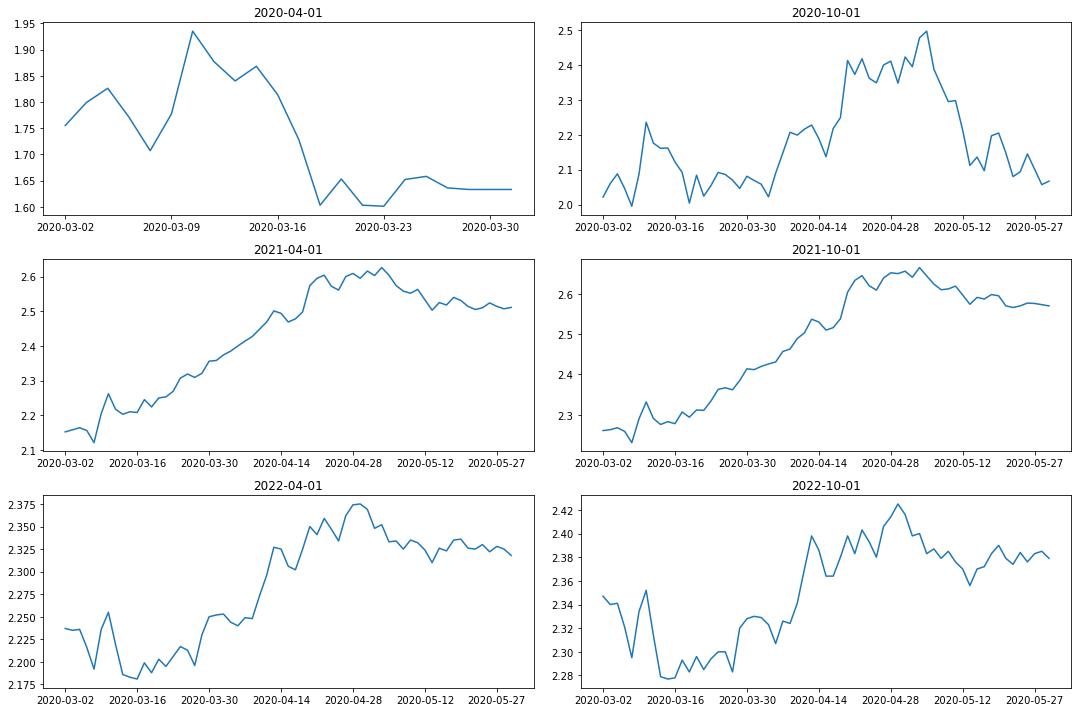

In [38]:
fig = plt.figure(figsize=(15,10), tight_layout=True)
grid = fig.add_gridspec(3, 2)

del_date = ["2020-04-01","2020-10-01","2021-04-01","2021-10-01","2022-04-01","2022-10-01"]
ax= [fig.add_subplot(grid[0,0]), fig.add_subplot(grid[0,1]), fig.add_subplot(grid[1,0]), fig.add_subplot(grid[1,1]), 
     fig.add_subplot(grid[2,0]), fig.add_subplot(grid[2,1])]

for i in range(len(del_date)):
    NG_price.loc[NG_price.delivdate == del_date[i]].plot(ax=ax[i], x='pricedate', y='price', xlabel="", legend=False)
    ax[i].set_title(del_date[i])


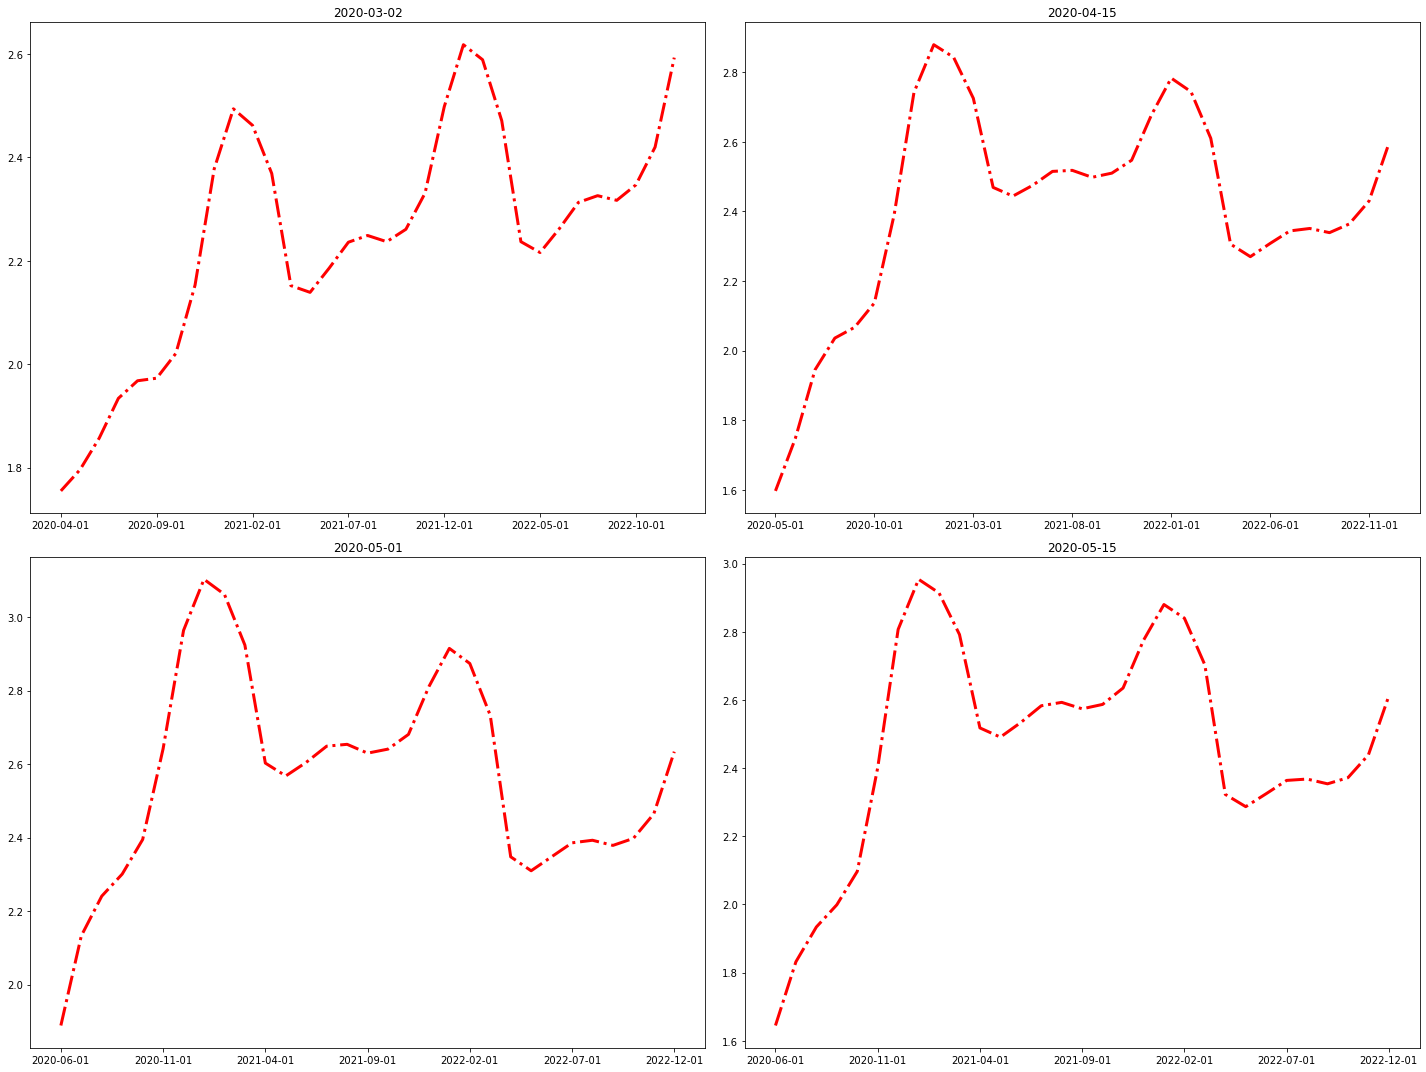

In [39]:
fig = plt.figure(figsize=(20,15), tight_layout=True)
grid = fig.add_gridspec(2,2)

pri_date = ["2020-03-02","2020-04-15","2020-05-01","2020-05-15"]
ax= [fig.add_subplot(grid[0,0]), fig.add_subplot(grid[0,1]), fig.add_subplot(grid[1,0]), fig.add_subplot(grid[1,1])]

for i in range(len(pri_date)):
    NG_price.loc[NG_price.pricedate == pri_date[i]].plot(ax=ax[i], linestyle='dashdot', color='r', linewidth=3, markersize=15,
                                                         x='delivdate', y='price', xlabel="", legend=False)
    #y=NG_df.F.mean()
    #xmin = NG_price.delivdate.min()
    #xmax = NG_price.delivdate.max
    #plt.hlines(y, xmin, xmax , colors='b', linestyles='dashdot')
    ax[i].set_title(pri_date[i])


In [40]:
NG_price.pricedate = pd.to_datetime(NG_price.pricedate, format='%Y-%m-%d')
NG_price.delivdate = pd.to_datetime(NG_price.delivdate, format='%Y-%m-%d')


int_rate.pricedate = pd.to_datetime(int_rate.pricedate, format='%Y-%m-%d')

for i in range(len(int_rate.pricedate)):
    p_time = int_rate.pricedate[i]
    m_time = int_rate.maturity[i]
    maturedate  = p_time + to_offset(m_time)
    int_rate.maturity[i] = maturedate

int_rate.maturity =  pd.to_datetime(int_rate.maturity, format='%Y-%m-%d %H:%M:%s')  
int_rate = int_rate.loc[int_rate.maturity < "2022-12-31"]

delv_date = int_rate.maturity - pd.offsets.MonthBegin(1, normalize=True)
#delv_date
#int_rate = int_rate.insert(1, "delivdate", delv_date, allow_duplicates=True)
#int_rate
#int_rate = int_rate.rename(columns={"maturity":"delivdate"})
#int_rate.maturity = int_rate.pricedate.resamplea(int_rate.maturity , origin=int_rate.maturity )    


<ipython-input-40-57ca7a4e1b74>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_rate.maturity[i] = maturedate


In [41]:
int_rate = int_rate.assign(delivdate = delv_date)

vol_frame = [NG_impvol_2020 , NG_impvol_2021 , NG_impvol_2022]

NG_vols = pd.concat(vol_frame , join ='inner').drop(['volatilityindex'],axis=1)

NG_vols.volatilitydate = pd.to_datetime(NG_vols.volatilitydate)
NG_vols.begtime = pd.to_datetime(NG_vols.begtime)

NG_vols = NG_vols.rename(columns={"volatilitydate":"t","begtime":"Tf","strikeprice":"K","volatility":"sigma"})


#display(NG_price, int_rate)
#NG_price.info()
#int_rate.info()



NG_pri_int = pd.merge(NG_price, int_rate, how= 'inner', on = ['pricedate','delivdate'])

NG_pri_int = NG_pri_int.rename(columns={"pricedate":"t","delivdate":"Tf", "price":"F", "bidrate":"r"})


#display(NG_vols, NG_pri_int)

NG_df = NG_vols.merge(NG_pri_int , how='inner' , on =['t','Tf'], sort = True)

Te = NG_df.Tf - DateOffset(days=1)
NG_df = NG_df.assign(Te = Te)

#NG_df = NG_df.loc[NG_df.Tf > NG_df.Te]
NG_df = NG_df.reset_index(drop=True)
display(NG_df)


,t,K,Tf,sigma,F,maturity,r,Te
0,2020-03-02,1.03,2020-04-01,0.592,1.755,2020-04-30,0.995003,2020-03-31
1,2020-03-02,1.08,2020-04-01,0.576,1.755,2020-04-30,0.995003,2020-03-31
2,2020-03-02,1.13,2020-04-01,0.562,1.755,2020-04-30,0.995003,2020-03-31
3,2020-03-02,1.18,2020-04-01,0.548,1.755,2020-04-30,0.995003,2020-03-31
4,2020-03-02,1.23,2020-04-01,0.535,1.755,2020-04-30,0.995003,2020-03-31
...,...,...,...,...,...,...,...,...
147403,2020-05-29,4.80,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147404,2020-05-29,4.85,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147405,2020-05-29,4.90,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31
147406,2020-05-29,4.95,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31


In [42]:
def call_option (df):
    
    delta_t = df.Te - df.t
    time_diff = (delta_t.dt.days)/365
    
    d1 = (np.log(df.F / df.K) + (0.5 * (df.sigma**2)*time_diff)) / (df.sigma * np.sqrt(time_diff))
    d2 = (np.log(df.F / df.K) - (0.5 * (df.sigma**2)*time_diff)) / (df.sigma * np.sqrt(time_diff))
    
    Call = np.exp(- (df.r/100) * time_diff) * (df.F * si.norm.cdf(d1) - df.K * si.norm.cdf(d2))
    
    return Call

def put_option (df):
    
    delta_t = df.Te - df.t
    time_diff = (delta_t.dt.days)/365
    
    d1 = (np.log(df.F / df.K) + (0.5 * (df.sigma**2)*time_diff)) / (df.sigma * np.sqrt(time_diff))
    d2 = (np.log(df.F / df.K) - (0.5 * (df.sigma**2)*time_diff)) / (df.sigma * np.sqrt(time_diff))
    
    Put = np.exp(- (df.r/100) * time_diff) * (- (df.F * si.norm.cdf(-d1)) + df.K * si.norm.cdf(-d2))
    
    return Put

,t,K,Tf,sigma,F,maturity,r,Te,call,put
0,2020-03-02,1.03,2020-04-01,0.592,1.755,2020-04-30,0.995003,2020-03-31,0.724469,0.000042
1,2020-03-02,1.08,2020-04-01,0.576,1.755,2020-04-30,0.995003,2020-03-31,0.674555,0.000088
2,2020-03-02,1.13,2020-04-01,0.562,1.755,2020-04-30,0.995003,2020-03-31,0.624688,0.000181
3,2020-03-02,1.18,2020-04-01,0.548,1.755,2020-04-30,0.995003,2020-03-31,0.574902,0.000357
4,2020-03-02,1.23,2020-04-01,0.535,1.755,2020-04-30,0.995003,2020-03-31,0.525268,0.000683
...,...,...,...,...,...,...,...,...,...,...
147403,2020-05-29,4.80,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31,0.012839,2.349921
147404,2020-05-29,4.85,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31,0.011952,2.398654
147405,2020-05-29,4.90,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31,0.011127,2.447448
147406,2020-05-29,4.95,2022-11-01,0.227,2.445,2022-11-30,0.315002,2022-10-31,0.010360,2.496300


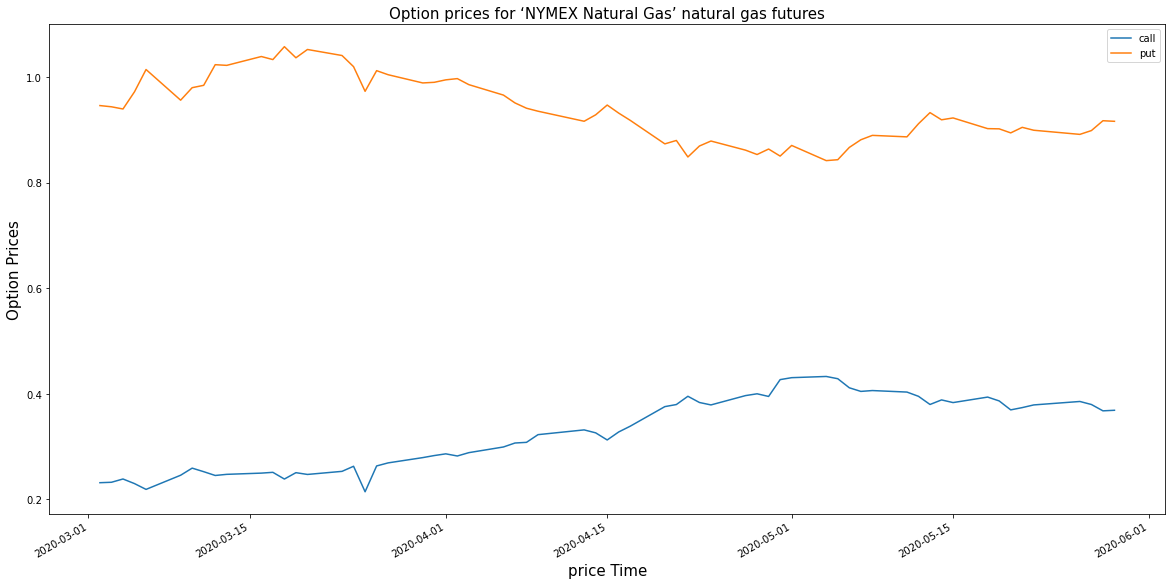

In [44]:
call = call_option(NG_df)
put = put_option(NG_df)

NG_option = NG_df.assign(call =call, put = put)
display(NG_option)

NG_option = NG_option.drop(["Tf","F","K", "r","Te","sigma"], axis=1).groupby("t", dropna=False).mean()


NG_option.plot.line(subplots = False ,figsize=(20,10))
plt.xlabel('price Time',size=15)
plt.ylabel('Option Prices',size=15)
plt.title('Option prices for ‘NYMEX Natural Gas’ natural gas futures',size=15)
plt.legend()